In [2]:
!date
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')


Thu Apr  6 10:52:46 -03 2017


In [3]:
import pymc3 as pm, theano.tensor as tt

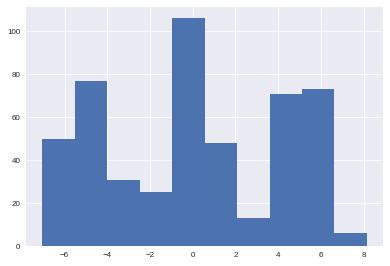

In [4]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [5]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)